<a href="https://colab.research.google.com/github/YogishGayatri/BuildLLM/blob/main/Instruction_Finetuning_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import os
import urllib

def load_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "/content/drive/My Drive/FinetuneProject/alpaca_data.json"

data = load_file(file_path)
#import random
#data = random.sample(data, 10000)

print("Number of entries:", len(data))

Number of entries: 52002


In [3]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.2 MB/s eta 0:00:00


In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [ ]:
def format_input_1(entry):
    instruction_text = " <|User|>\n" + "   "+entry['instruction'].rstrip('.').strip() + ':' + entry["input"] + "\n <|assistant|>\n   "
    return instruction_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Edit the following sentence to make it more concise.

### Input:
He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.

### Response:
He ran to the bus stop, due to arrive in five minutes.


In [ ]:
model_input = format_input_1(data[50])
desired_response = data[50]['output'].rstrip('.')
print(model_input + desired_response)

 <|User|>
   Edit the following sentence to make it more concise:He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.
 <|assistant|>
   He ran to the bus stop, due to arrive in five minutes


In [7]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 44201
Validation set length: 2601
Test set length: 5200


In [8]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [10]:
#Final Function for
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]


        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index #only targets are changed to not add it up to the learning loss

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [11]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [13]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [15]:
print("Train loader:")
first_batch = True
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    if first_batch:
        print(inputs[0])
        print(targets[0])
        first_batch = False

Streaming output truncated to the last 5000 lines.
torch.Size([4, 177]) torch.Size([4, 177])
torch.Size([4, 174]) torch.Size([4, 174])
torch.Size([4, 145]) torch.Size([4, 145])
torch.Size([4, 170]) torch.Size([4, 170])
torch.Size([4, 186]) torch.Size([4, 186])
torch.Size([4, 172]) torch.Size([4, 172])
torch.Size([4, 202]) torch.Size([4, 202])
torch.Size([4, 92]) torch.Size([4, 92])
torch.Size([4, 113]) torch.Size([4, 113])
torch.Size([4, 150]) torch.Size([4, 150])
torch.Size([4, 204]) torch.Size([4, 204])
torch.Size([4, 163]) torch.Size([4, 163])
torch.Size([4, 153]) torch.Size([4, 153])
torch.Size([4, 175]) torch.Size([4, 175])
torch.Size([4, 78]) torch.Size([4, 78])
torch.Size([4, 102]) torch.Size([4, 102])
torch.Size([4, 220]) torch.Size([4, 220])
torch.Size([4, 140]) torch.Size([4, 140])
torch.Size([4, 274]) torch.Size([4, 274])
torch.Size([4, 119]) torch.Size([4, 119])
torch.Size([4, 155]) torch.Size([4, 155])
torch.Size([4, 167]) torch.Size([4, 167])
torch.Size([4, 89]) torch.Siz

In [ ]:
inputs[0]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 18438,   391,   644, 11666,  4430,   318,
          287,   257, 35327,   835,    11,   351,  1342,   621,  1802,  2456,
           13,   198,   198, 21017, 18261,    25,   198,  8001,  9542,  4430,
          357, 20185,     8,   318,   262,  5339,   329,  9061,    11,  8217,
           11,   290, 14193,   284,  1620,  8861,   326, 16083,  2421,  1692,
         4430,    11,   884,   355,  1917,    12,    82, 10890,    11,  2551,
           12,  8601,    11,  3303,  7587,    11,   290,  4441,   290, 22650,
         7572,    13,  9552,  3341,   389,  3562,   284, 29308,  1692,  4430,
           11,  1690, 10616,  1588,  6867,   286,  1366,   284,   307,  8776,
          290,  6596,   625,   640,    13, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [ ]:
targets[0]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 18438,   391,   644, 11666,  4430,   318,   287,
          257, 35327,   835,    11,   351,  1342,   621,  1802,  2456,    13,
          198,   198, 21017, 18261,    25,   198,  8001,  9542,  4430,   357,
        20185,     8,   318,   262,  5339,   329,  9061,    11,  8217,    11,
          290, 14193,   284,  1620,  8861,   326, 16083,  2421,  1692,  4430,
           11,   884,   355,  1917,    12,    82, 10890,    11,  2551,    12,
         8601,    11,  3303,  7587,    11,   290,  4441,   290, 22650,  7572,
           13,  9552,  3341,   389,  3562,   284, 29308,  1692,  4430,    11,
         1690, 10616,  1588,  6867,   286,  1366,   284,   307,  8776,   290,
         6596,   625,   640,    13, 50256,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/FinetuneProject')

In [ ]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel
from previous_chapters import load_weights_into_gpt

gpt_dir = "/content/drive/My Drive/FinetuneProject/gpt2"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir=gpt_dir
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/checkpoint
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/encoder.json
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/hparams.json
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/model.ckpt.index
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: /content/drive/My Drive/FinetuneProject/gpt2/355M/vocab.bpe


In [ ]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel
from previous_chapters import load_weights_into_gpt

gpt_dir = "/content/drive/My Drive/FinetuneProject/gpt2"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model = GPTModel(BASE_CONFIG)
model.eval();

In [ ]:
checkpoint = torch.load("/content/drive/My Drive/FinetuneProject/FinetunedModel_AlpacaDataset__4_withopt.pth",map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-11-fcacd19036e1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/My Drive/FinetuneProject/FinetunedModel_AlpacaDatase

<All keys matched successfully>

In [ ]:
data = {
        "instruction": "",
        "input": "\\<noinput>", #\\<noinput>
}
print(data)

{'instruction': 'Can you give synonym of word retaliate', 'input': '\\<noinput>'}


In [ ]:
torch.manual_seed(123)
input_text = format_input(data)
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Can you give synonym of word retaliate

### Input:
\<noinput>


In [ ]:
from previous_chapters import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Can you give synonym of word retaliate

### Input:
\<noinput>

### Response:
Respond to


In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:
Respond to


In [ ]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [ ]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.2639075756072997
Validation loss: 3.41228928565979


In [ ]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.477, Val loss 2.750
Ep 1 (Step 000005): Train loss 1.863, Val loss 1.955
Ep 1 (Step 000010): Train loss 1.674, Val loss 1.850
Ep 1 (Step 000015): Train loss 1.525, Val loss 1.821
Ep 1 (Step 000020): Train loss 1.516, Val loss 1.800
Ep 1 (Step 000025): Train loss 1.574, Val loss 1.781
Ep 1 (Step 000030): Train loss 1.566, Val loss 1.777
Ep 1 (Step 000035): Train loss 1.497, Val loss 1.768
Ep 1 (Step 000040): Train loss 1.522, Val loss 1.774
Ep 1 (Step 000045): Train loss 1.447, Val loss 1.766
Ep 1 (Step 000050): Train loss 1.520, Val loss 1.745
Ep 1 (Step 000055): Train loss 1.453, Val loss 1.723
Ep 1 (Step 000060): Train loss 1.501, Val loss 1.716
Ep 1 (Step 000065): Train loss 1.489, Val loss 1.738
Ep 1 (Step 000070): Train loss 1.454, Val loss 1.749
Ep 1 (Step 000075): Train loss 1.535, Val loss 1.753
Ep 1 (Step 000080): Train loss 1.616, Val loss 1.743
Ep 1 (Step 000085): Train loss 1.456, Val loss 1.723
Ep 1 (Step 000090): Train loss 1.712, Val loss

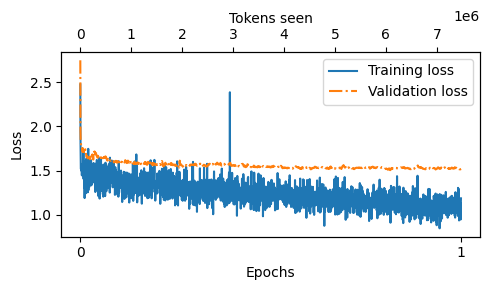

In [ ]:
from previous_chapters import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#There is no memorization

In [ ]:
import torch

In [ ]:
checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'tokens_seen': tokens_seen
    }

# Save the checkpoint
torch.save(checkpoint, "/content/drive/My Drive/FinetuneProject/FinetunedModel_AlpacaDataset__4_withopt.pth")

In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain how using transitional words help in writing

### Input:
"<noinput>"

### Response:
Transitional words help to create a more structured and organized writing style. They help to create a more consistent structure and make it easier to remember.


In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:
DNA replication is a process that allows the genetic material to be replicated in a cell. It involves the transfer of DNA molecules from one cell to another


In [ ]:
checkpoint = torch.load("/content/drive/My Drive/FinetuneProject/FinetunedModel10k_3_withopt.pth",map_location=torch.device('cpu'), weights_only = True)

In [ ]:
model.state_load_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
from tqdm import tqdm
import random
test_data = random.sample(test_data, 500)
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("/content/drive/My Drive/FinetuneProject/instruction-data-with-response_Final.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 500/500 [17:02<00:00,  2.04s/it]
